In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import bokeh
import os
import geopandas
pd.options.display.max_colwidth=200
%matplotlib inline

## Get the data

In [41]:
# data directory
data_dir = "../data"
raw_data = os.path.join(data_dir, "raw")

# read in the data
df = pd.read_csv(os.path.join(raw_data, "summary_listings.csv"))
nbhoods = geopandas.read_file(os.path.join(raw_data, "neighbourhoods.geojson"))
subway = geopandas.read_file(os.path.join(raw_data, "subway.geojson"))

# use only Manhattan nbgroup and roomtype: entire home/apt
manhattan_df = df[(df.neighbourhood_group == 'Manhattan') & (df.room_type == 'Entire home/apt')]
manhattan_nbhoods = nbhoods[nbhoods.neighbourhood_group == 'Manhattan']


# construct a geodataframe
manhattan_df = geopandas.GeoDataFrame(manhattan_df, geometry=geopandas.points_from_xy(manhattan_df.longitude, 
                                                                            manhattan_df.latitude))

# filter 
cols = ['price', 'neighbourhood', 'neighbourhood_group', 'geometry']
manhattan_df = manhattan_df[cols]

Check the shape of each of the data frames. 
* **manhattan_df**: Contains the airbnb data for just Manhattan neighbourhoods with room type entire home/apt
* **manhattan_nbhoods**: Contains just the 32 Manhattan neighbourhoods.
* **subway**: Contains subway data for all 5 boroughs. So, we need to filter this to include on Manhattan subway stations. To do this we need to do some work, since the subway data is not broken down by neighbhourhoods.

In [42]:
display(manhattan_df.shape)
display(manhattan_nbhoods.shape)
display(subway.shape)

(13054, 4)

(32, 3)

(473, 6)

To obtain the neighbourhoods of subway stations, we need to perform what is known as a **spatial join**.

In [43]:
subway.head()

,name,url,line,objectid,notes,geometry
0,Astor Pl,http://web.mta.info/nyct/service/,4-6-6 Express,1,"4 nights, 6-all times, 6 Express-weekdays AM southbound, PM northbound",POINT (-73.99106999861966 40.73005400028978)
1,Canal St,http://web.mta.info/nyct/service/,4-6-6 Express,2,"4 nights, 6-all times, 6 Express-weekdays AM southbound, PM northbound",POINT (-74.00019299927328 40.71880300107709)
2,50th St,http://web.mta.info/nyct/service/,1-2,3,"1-all times, 2-nights",POINT (-73.98384899986625 40.76172799961419)
3,Bergen St,http://web.mta.info/nyct/service/,2-3-4,4,"4-nights, 3-all other times, 2-all times",POINT (-73.97499915116808 40.68086213682956)
4,Pennsylvania Ave,http://web.mta.info/nyct/service/,3-4,5,"4-nights, 3-all other times",POINT (-73.89488591154061 40.66471445143568)


In [44]:
manhattan_nbhoods.head()

,neighbourhood,neighbourhood_group,geometry
18,Battery Park City,Manhattan,"(POLYGON ((-74.01375400000001 40.71369, -74.014262 40.710928, -74.016542 40.704733, -74.01617400000001 40.702572, -74.01563 40.701862, -74.01512700000001 40.70139, -74.014008 40.701043, -74.013959..."
43,Chinatown,Manhattan,"(POLYGON ((-73.99999099999999 40.717977, -73.998636 40.717077, -73.99779100000001 40.716793, -73.996478 40.719048, -73.99480800000001 40.718457, -73.989155 40.716708, -73.9902 40.714665, -73.99012..."
52,Chelsea,Manhattan,"(POLYGON ((-73.993464 40.75219, -73.987937 40.749855, -73.987933 40.749853, -73.987973 40.749467, -73.991356 40.744763, -73.99421100000001 40.741013, -73.989777 40.739169, -73.990371 40.737098, -7..."
53,Civic Center,Manhattan,"(POLYGON ((-73.99799400000001 40.712722, -73.99777 40.711971, -74.002363 40.711591, -74.003337 40.711236, -74.003355 40.71123, -74.00366200000001 40.711487, -74.005358 40.712151, -74.005769 40.712..."
80,East Harlem,Manhattan,"(POLYGON ((-73.93383 40.819521, -73.93383 40.819521, -73.933829 40.815585, -73.93394499999999 40.815588, -73.93394499999999 40.815588, -73.93394600000001 40.815588, -73.934015 40.814484, -73.93385..."


Here, our goal is to find out whether each of the subway stations - represented by `Point()` objects, is contained within the neighbourhood - represented by `Polygon()` objects. One way to do this, is to extract the neighbourhood polygon for let's say "Battery Park City", and then, use the `within()` GeoSeries method to check whether the subway point is within the neighbourhood. This works fine, but what if we want to do this for each and every neighbourhood? 

This is where a **spatial join** comes handy. Since the neighbourhood column is part of `manhattan_nbhoods` dataframe, we need to combine/join both `manhattan_nbhoods and subway` datasets. **Joining on location rather than on a shared column is called a spatial join**. 

In [45]:
manhattan_subway = geopandas.sjoin(subway, 
                         manhattan_nbhoods[['neighbourhood', 'geometry']],
                        op='within')

In [46]:
manhattan_subway.head()

,name,url,line,objectid,notes,geometry,index_right,neighbourhood
0,Astor Pl,http://web.mta.info/nyct/service/,4-6-6 Express,1,"4 nights, 6-all times, 6 Express-weekdays AM southbound, PM northbound",POINT (-73.99106999861966 40.73005400028978),87,East Village
145,1st Ave,http://web.mta.info/nyct/service/,L,146,L-all times,POINT (-73.98168087489128 40.73097497580066),87,East Village
370,Lower East Side - 2nd Ave,http://web.mta.info/nyct/service/,F,371,F-all times,POINT (-73.98993800003434 40.72340166574911),87,East Village
382,3rd Ave,http://web.mta.info/nyct/service/,L,383,L-all times,POINT (-73.98575000112093 40.73269099971662),87,East Village
383,Union Sq - 14th St,http://web.mta.info/nyct/service/,L,384,L-all times,POINT (-73.99066976901818 40.73476331217923),87,East Village


In [47]:
manhattan_subway.shape

(146, 8)

In [48]:
manhattan_subway.neighbourhood.value_counts()

Midtown                18
Financial District     14
Harlem                 14
Washington Heights     11
Upper East Side        10
Chelsea                 9
Theater District        8
SoHo                    8
Upper West Side         7
Tribeca                 6
East Village            6
West Village            5
Lower East Side         4
East Harlem             4
Inwood                  4
Civic Center            3
Flatiron District       2
Morningside Heights     2
Gramercy                2
Hell's Kitchen          2
NoHo                    2
Roosevelt Island        1
Marble Hill             1
Little Italy            1
Greenwich Village       1
Chinatown               1
Name: neighbourhood, dtype: int64

So, this seems right, we have **146** subway stations just in Manhattan. Astounding!

### Check the Coordinate Reference System of the geodataframe
Before I move further to plotting this data on the map and doing distance calculations, it is vital to ensure that all locations are expressed in a common CRS. Moreover, NYC uses a specific EPSG value of 2829 or 32117. 

Reference: https://spatialreference.org/ref/?search=New+york&srtext=Search

In [49]:
print(manhattan_df.crs)
print(manhattan_nbhoods.crs)
print(manhattan_subway.crs)

None
{'init': 'epsg:4326'}
{'init': 'epsg:4326'}


The CRS attribute is missing for our airbnb dataset. We can set this easily by doing:

In [50]:
manhattan_df.crs = {'init': 'epsg:4326'}

In [51]:
print(manhattan_df.crs)
print(manhattan_nbhoods.crs)
print(manhattan_subway.crs)

{'init': 'epsg:4326'}
{'init': 'epsg:4326'}
{'init': 'epsg:4326'}


In [52]:
# To avoid SettingWithCopyWarning, store the result in a new dfs.
manhattan_df_crs = manhattan_df.to_crs(epsg=2829)
manhattan_nbhoods_crs = manhattan_nbhoods.to_crs(epsg=2829)
manhattan_subway_crs = manhattan_subway.to_crs(epsg=2829)

In [53]:
print(manhattan_df_crs.crs)
print(manhattan_nbhoods_crs.crs)
print(manhattan_subway_crs.crs)

{'init': 'epsg:2829', 'no_defs': True}
{'init': 'epsg:2829', 'no_defs': True}
{'init': 'epsg:2829', 'no_defs': True}


## Plot all the data

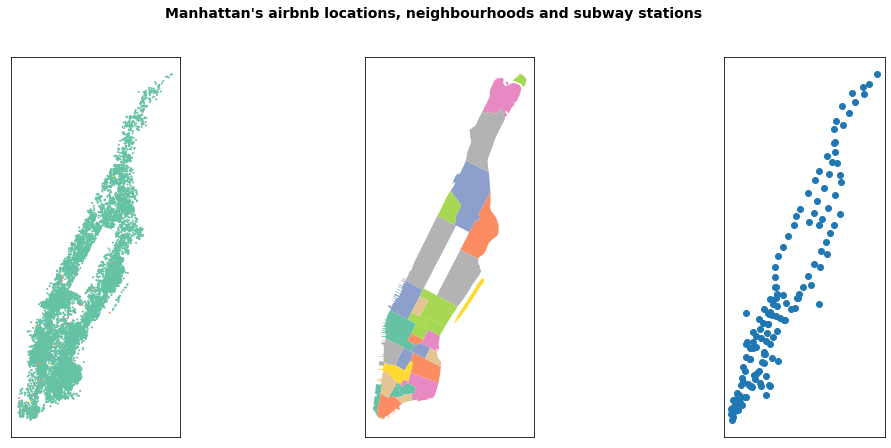

In [73]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(18, 7)

# airbnb locations
ax1 = manhattan_df_crs.plot(ax=ax1, 
                            column='price', 
                            cmap='Set2', 
                            markersize=1)
ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)

# nbhoods
ax2 = manhattan_nbhoods_crs.plot(ax=ax2, 
                                 column='neighbourhood', 
                                 cmap='Set2')
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)

# subway stations
ax3 = manhattan_subway_crs.plot(ax=ax3)
ax3.axes.get_xaxis().set_visible(False)
ax3.axes.get_yaxis().set_visible(False)


plt.suptitle("Manhattan's airbnb locations, neighbourhoods and subway stations", 
             fontsize=14, fontweight='bold')
plt.show()

### EDA: Calculate the median neighbourhood price

In [77]:
manhattan_df_crs_grouped = manhattan_df_crs.groupby('neighbourhood')[['price']].median()

median_price_df = pd.merge(manhattan_df_crs, manhattan_df_crs_grouped, 
                           left_on='neighbourhood', right_index=True)
median_price_df.rename({'price_x': 'price', 
                        'price_y': 'median_neighbourhood_price'}, 
                       axis=1, inplace=True)

manhattan_df_crs_grouped.sort_values(by='price', ascending=False)

,price
neighbourhood,
Tribeca,318.0
NoHo,252.5
Flatiron District,249.0
Theater District,240.0
SoHo,240.0
Battery Park City,225.0
Chelsea,225.0
Nolita,225.0
Financial District,221.0


### EDA: Plot the median neighbourhood price
Now let's overlay this on the map and color code it to visually see how the price differs by location.

In [106]:
median_price_df.head()

,price,neighbourhood,neighbourhood_group,geometry,median_neighbourhood_price
0,225,Midtown,Manhattan,POINT (469524.6984892281 86930.35771388965),220.0
229,250,Midtown,Manhattan,POINT (470677.7776314804 87551.5385397778),220.0
241,110,Midtown,Manhattan,POINT (470761.827736628 87397.31060812931),220.0
372,139,Midtown,Manhattan,POINT (469131.4848167276 85963.88072752411),220.0
380,145,Midtown,Manhattan,POINT (470934.6724387425 87213.49589937051),220.0


Color by median_neighbourhood_price

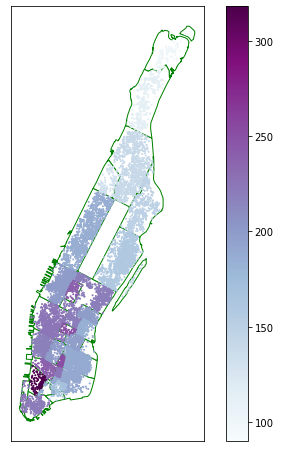

In [105]:
# nbhoods
ax = manhattan_nbhoods_crs.plot(figsize=(8,8), color='white', edgecolor='green')
ax = median_price_df.plot(ax=ax, markersize=1, legend=True,
                                 column='median_neighbourhood_price', 
                                 cmap='BuPu')

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.show()

In [108]:
manhattan_nbhoods_crs.drop('neighbourhood_group', axis=1, inplace=True)

In [109]:
manhattan_nbhoods_crs.head()

,neighbourhood,geometry
18,Battery Park City,"(POLYGON ((467122.2572863808 82421.16666408972, 467088.3056105837 82113.16723316014, 466915.7402487983 81419.5255550124, 466953.85987936 81180.43837542315, 467002.1446376443 81102.93164204141, 467..."
43,Chinatown,"(POLYGON ((468271.2982895938 82931.41173618173, 468388.7397763333 82834.82990154813, 468461.0727218391 82805.39227960705, 468564.6427924591 83059.09847071668, 468707.6920720575 82997.62324837463, ..."
52,Chelsea,"(POLYGON ((468710.6776326126 86747.3227028465, 469185.1456793678 86501.79746154339, 469185.4900922586 86501.5853396085, 469183.3801157149 86458.61653507431, 468913.0865981017 85927.74576283006, 46..."
53,Civic Center,"(POLYGON ((468457.235254533 82352.76782179784, 468478.621498909 82269.92045108535, 468091.7168221254 82216.29588924503, 468010.5642736031 82174.45053362568, 468009.0626965503 82173.7394760903, 467..."
80,East Harlem,"(POLYGON ((473521.1660731504 94375.56368291112, 473521.1660731504 94375.56368291112, 473534.4730513414 93938.43044907338, 473524.6752114975 93938.46758702045, 473524.6752114975 93938.46758702045, ..."


In [111]:
manhattan_df_crs_grouped.shape

(32, 1)

In [112]:
manhattan_df_crs_grouped.head()

,price
neighbourhood,
Battery Park City,225.0
Chelsea,225.0
Chinatown,170.0
Civic Center,187.0
East Harlem,150.0


In [114]:
cloropeth_price_df = pd.merge(manhattan_nbhoods_crs, manhattan_df_crs_grouped, 
                              left_on='neighbourhood', right_index=True)

In [115]:
cloropeth_price_df.head()

,neighbourhood,geometry,price
18,Battery Park City,"(POLYGON ((467122.2572863808 82421.16666408972, 467088.3056105837 82113.16723316014, 466915.7402487983 81419.5255550124, 466953.85987936 81180.43837542315, 467002.1446376443 81102.93164204141, 467...",225.0
43,Chinatown,"(POLYGON ((468271.2982895938 82931.41173618173, 468388.7397763333 82834.82990154813, 468461.0727218391 82805.39227960705, 468564.6427924591 83059.09847071668, 468707.6920720575 82997.62324837463, ...",170.0
52,Chelsea,"(POLYGON ((468710.6776326126 86747.3227028465, 469185.1456793678 86501.79746154339, 469185.4900922586 86501.5853396085, 469183.3801157149 86458.61653507431, 468913.0865981017 85927.74576283006, 46...",225.0
53,Civic Center,"(POLYGON ((468457.235254533 82352.76782179784, 468478.621498909 82269.92045108535, 468091.7168221254 82216.29588924503, 468010.5642736031 82174.45053362568, 468009.0626965503 82173.7394760903, 467...",187.0
80,East Harlem,"(POLYGON ((473521.1660731504 94375.56368291112, 473521.1660731504 94375.56368291112, 473534.4730513414 93938.43044907338, 473524.6752114975 93938.46758702045, 473524.6752114975 93938.46758702045, ...",150.0


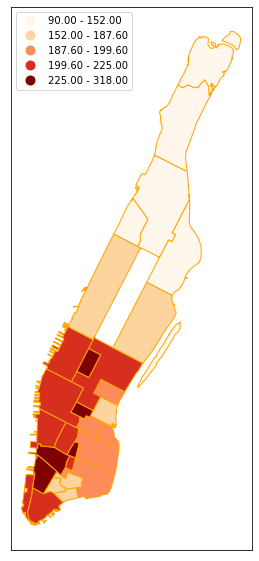

In [124]:
# nbhoods
ax = cloropeth_price_df.plot(figsize=(10,10), column='price', 
                             cmap='OrRd', scheme='quantiles', 
                             edgecolor='orange', legend=True, 
                             legend_kwds = {'loc':'upper left'})

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.show()